<a href="https://colab.research.google.com/github/Arpit1118/Pytorch/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

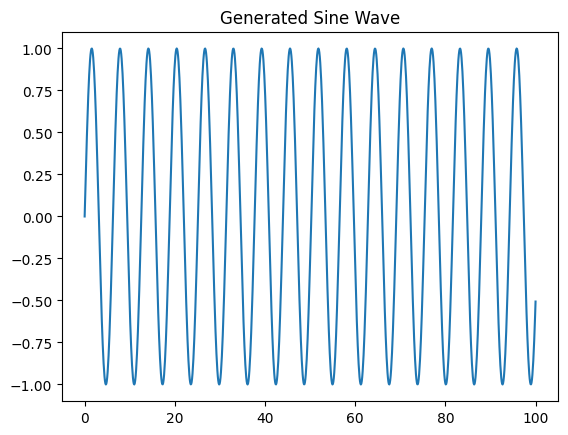

In [2]:
# Generate some sample data (sine wave)
t = np.linspace(0, 100, 1000)  # 1000 points from 0 to 100
data = np.sin(t)

# Visualize the sine wave
plt.plot(t, data)
plt.title('Generated Sine Wave')
plt.show()

# Rescale the data to [0, 1] for better training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))


In [3]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Create sequences of length 10
seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Add an additional dimension for the LSTM input (batch_size, seq_length, input_size)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Shape will be (batch_size, seq_length, input_size)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Only take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        predictions = self.linear(lstm_out)
        return predictions


In [5]:
input_size = 1  # since we are using univariate data
hidden_layer_size = 64  # You can adjust this
output_size = 1  # We are predicting the next value

# Initialize the model
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
epochs = 100  # Number of training epochs
for epoch in range(epochs):
    model.train()

    # Forward pass
    optimizer.zero_grad()
    y_pred = model(X_train)

    # Compute the loss
    loss = loss_fn(y_pred, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 10/100, Loss: 0.16579939424991608
Epoch 20/100, Loss: 0.08829968422651291
Epoch 30/100, Loss: 0.07371905446052551
Epoch 40/100, Loss: 0.05607634410262108
Epoch 50/100, Loss: 0.03535373881459236
Epoch 60/100, Loss: 0.018640099093317986
Epoch 70/100, Loss: 0.012639866210520267
Epoch 80/100, Loss: 0.008199876174330711
Epoch 90/100, Loss: 0.005826758220791817
Epoch 100/100, Loss: 0.004011389799416065


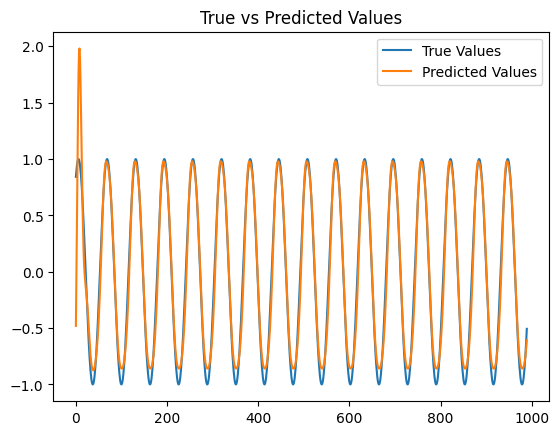

In [7]:
model.eval()

# Use the model to predict the next value in the sequence
with torch.no_grad():
    predictions = model(X_train)

# Convert the predictions back to the original scale
predicted_values = scaler.inverse_transform(predictions.numpy())

# Convert actual values back to the original scale
true_values = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))

# Visualize the predicted vs true values
plt.plot(true_values, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()


**Amazon Stock Forecasting (TIme series) using LSTM**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [9]:
data = pd.read_csv('/content/AMZN.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [10]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

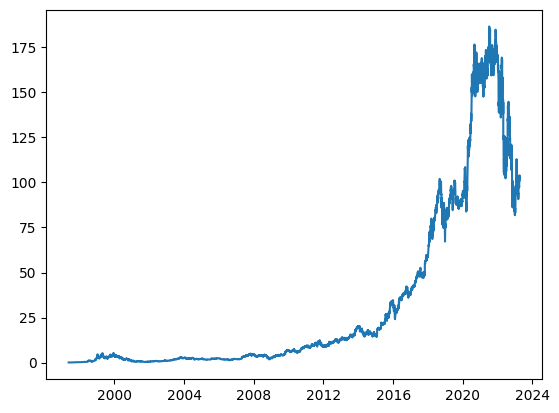

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [13]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [14]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [15]:
shifted_df_as_np.shape

(6509, 8)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [17]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [18]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [19]:
split_index = int(len(X) * 0.95)

split_index

6183

In [20]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [21]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [22]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [23]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [24]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [27]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [28]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [29]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.185
Batch 200, Loss: 0.066
Batch 300, Loss: 0.029

Val Loss: 0.041
***************************************************

Epoch: 2
Batch 100, Loss: 0.011
Batch 200, Loss: 0.008
Batch 300, Loss: 0.005

Val Loss: 0.013
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.007
***************************************************

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
*****************

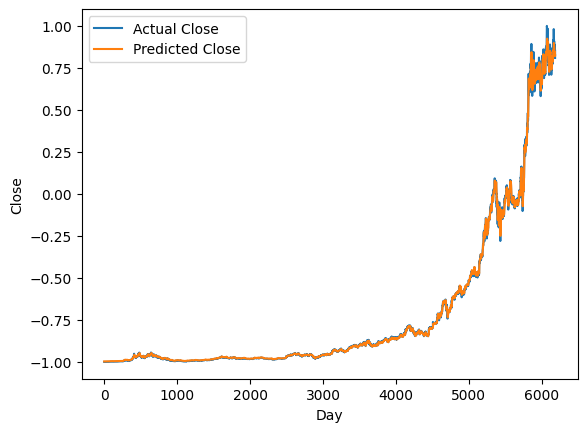

In [30]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [31]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.35521437,   0.35544781,   0.35520325, ..., 170.69398421,
       169.82701705, 170.35006978])

In [32]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

<ipython-input-32-2b76640e40df>:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

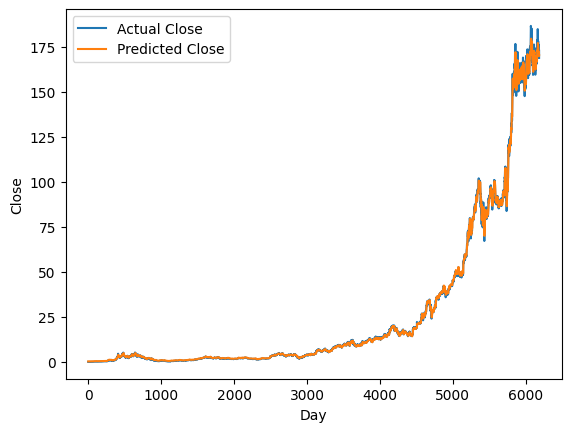

In [33]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [34]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.45895814, 169.21428956, 168.24965507, 168.56723511,
       168.97383404, 169.27194953, 169.07223505, 169.24970592,
       168.94305316, 168.58527677, 167.75081352, 168.23389223,
       167.75064678, 166.52181246, 165.33750983, 164.31993977,
       163.30529329, 163.84853868, 164.19082457, 163.26561385,
       162.94985132, 161.70837783, 159.99274086, 157.23236017,
       152.03223024, 149.18031282, 145.62152998, 142.93630623,
       141.66162852, 142.73858712, 145.75040618, 148.41679901,
       149.93258255, 146.44119751, 150.92294559, 153.95550201,
       157.09226768, 159.02880113, 159.5394259 , 157.87960916,
       157.31815536, 157.19870018, 157.6815788 , 156.87216045,
       155.64693891, 153.98001889, 150.89706697, 151.19611623,
       152.35255599, 153.1431323 , 152.87909366, 153.01917504,
       151.59617881, 149.7643993 , 145.29288372, 141.66497451,
       140.66933125, 143.1842152 , 144.52958112, 144.07956213,
       145.85453762, 149.13271305, 152.71352829, 156.35

In [35]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

<ipython-input-35-de35d29ffb5f>:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

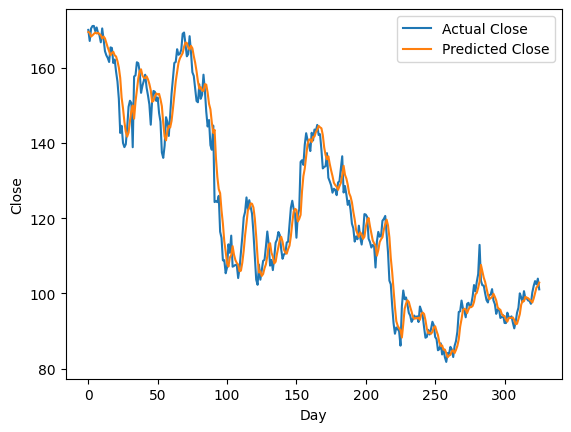

In [36]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()